In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#import warnings
#warnings.filterwarnings('ignore')

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
#print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

# Part 1. Read data and class distribution.

In this part I will read the data and obtain the dataset: Diabetes.
After that, I will analyze a bit the data and see the distribution. The most important question of this part are:
* How is the data distributed? 
*  Is it balanced?

Is important to know the answer to those questions, to know the evaluation metrics that we wil use.

In [7]:
diabetes= pd.read_csv("diabetes.csv")
print (diabetes.shape)
print ("--"*30)
print (diabetes.info())


(768, 9)
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


From 768 samples, we have no null values. So the data is perfectly clean. At least in apperance.

In [8]:
diabetes.head()
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Now, we can see the problem. I am not a doctor but I imagine that having a Blood Pressure of 0 is equivalent to be dead. Also, a SkinThickness, insulin, glucose or BMI of 0 do not correlate good with the fact of being a living being.

Because of that, the data is NOT clean, and we need to take action.

But before we take action, it is useful to know how the data is distributed. At the end of the day, I need to do a binary classification. 

Given a few features, I need to predict if someone has diabetes. Yes or no. So, knowing the distribution of the data is essential.

In [9]:
# class distribution
print(" Outcome distribution")
print(diabetes.groupby('Outcome').size())

 Outcome distribution
Outcome
0    500
1    268
dtype: int64


So, we have 500 person with diabetes and 268 whithout it. We can clearly see that is an unbalanced dataset.
It is critical to know this for a few reasons:

* The algorithms of machine learning like LogisticRegression os SVM, tend to think that the data is balanced. But if the data is unbalanced they will put more weight on the majority class. In this case, the positive Outcome of diabetes. And this is very very bad.
* The accuracy is not a useful metric now. For example, I have 100 emails, 99 good emails and 1 spam email. If I created and algorithm that always is going to put all emails in your inbox, then I will reach and accuracy of 99%. But I will not be performing a good job, becauase my job is to be sure that non spam came to your inbox. Because of that I will use other metrics, such as Roc_Auc, sensitivity, specificity...


# Part 2: EDA.

Lets see how the data is distributed and how the features and outcome are correlated.

In [10]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

## Data cleaning

If we look at the data, we see that some features has null values, in this case with the apperances of 0. Because later I will perform some modeling with the raw data, now I am going to clean the data in a copy dataset.

In [11]:
#1) Replace 0 values to NaN values. Then sum the null values in each of those features,
#to know how many null values we have.
diabetes_copy=diabetes.copy(deep=True) ## We will need later the diabetes dataset with the 0s.

diabetes[["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]]=diabetes[["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]].replace(0,np.NaN)
print (diabetes.isnull().sum())
diabetes.describe()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


I will replace all those values with the median.  The SkinThickness and insulin have a lot of null values. Because of that I will need to pay extra attention to those features in the visualizations tha I will make later.

In [12]:
# We replace the NaN values with the mean or median.
# Glucose and BloodPressure dont have much outliers, and we need little data to fill. The mean will be enough.
# The others, has a huge disparity between some samples, and we need a lot of data. So the median is best.
diabetes["Glucose"].fillna(diabetes["Glucose"].mean(),inplace=True)
diabetes["BloodPressure"].fillna(diabetes["BloodPressure"].mean(),inplace=True)
diabetes["SkinThickness"].fillna(diabetes["SkinThickness"].median(),inplace=True)
diabetes["Insulin"].fillna(diabetes["Insulin"].median(),inplace=True)
diabetes["BMI"].fillna(diabetes["BMI"].median(),inplace=True)

print (diabetes.isnull().sum())
print ('--'*40)
diabetes.info()
print ('--'*40)
diabetes.head()
diabetes.describe()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null float64
BloodPressure               768 non-null float64
SkinThickness               768 non-null float64
Insulin                     768 non-null float64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(6), int64(3)
memory usage: 54.1 KB
----------------------------------------------

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.108073,140.671875,32.455208,0.471876,33.240885,0.348958
std,3.369578,30.435949,12.096346,8.791221,86.383060,6.875177,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.202592,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Perfect. The data is now perfectly clean.

## Visualizations

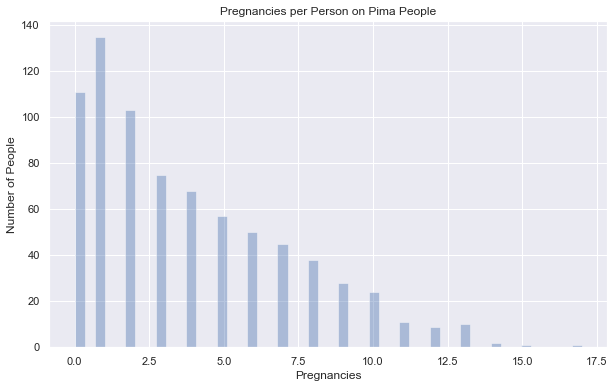

In [13]:
plt.figure(figsize=(10,6))
sns.distplot(diabetes['Pregnancies'],kde=False,bins=50)
plt.title('Pregnancies per Person on Pima People')
plt.ylabel('Number of People')
plt.show()

In [14]:
print('Average amount of children had by a Pima woman: ' + str(diabetes['Pregnancies'].mean()))


Average amount of children had by a Pima woman: 3.8450520833333335


Some of the Pima women are having a lot of children, but the most popular case is 1 child per women. In anycase, later, with the bivariate plots we will see how is the relationship between pregnancies and diabetes.

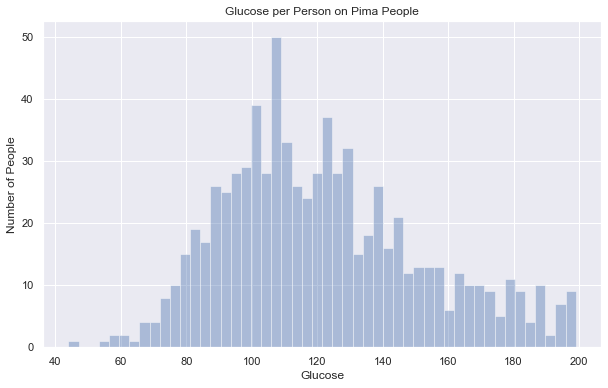

In [15]:
plt.figure(figsize=(10,6))
sns.distplot(diabetes['Glucose'],kde=False,bins=50)
plt.title('Glucose per Person on Pima People')
plt.ylabel('Number of People')
plt.show()

Kind of a normal distribution. This is good. I will not need to make any changes on this variable. Later, we will see how is the correlation between Glucose and Diabetes.


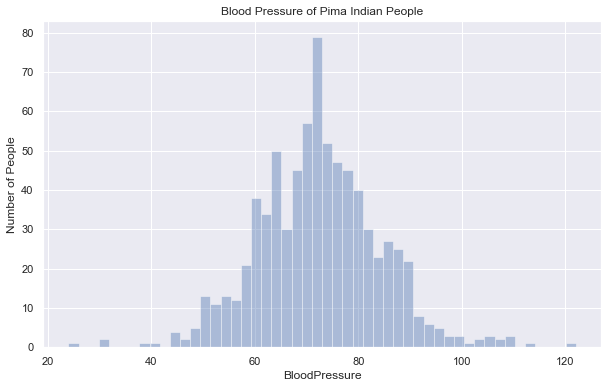

In [16]:
plt.figure(figsize=(10,6))
sns.distplot(diabetes['BloodPressure'],kde=False,bins=50)
plt.title('Blood Pressure of Pima Indian People')
plt.ylabel('Number of People')
plt.show()

Again, good news. It seems to be a normal distribution, and that means no change on the data later. Is a good distribution for the algorithms. Later we will see the relation it has with other features.

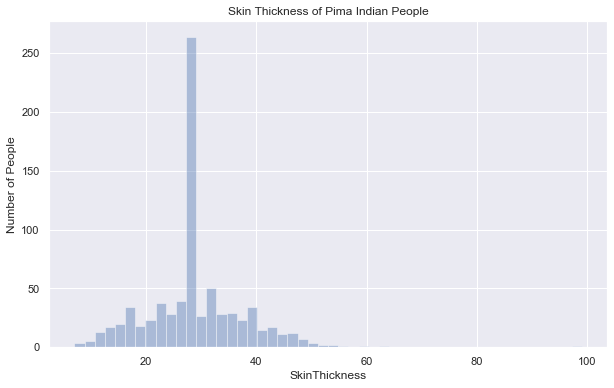

In [17]:
plt.figure(figsize=(10,6))
sns.distplot(diabetes['SkinThickness'],kde=False,bins=50)
plt.title('Skin Thickness of Pima Indian People')
plt.ylabel('Number of People')
plt.show()

Is completely normal that it looks like that. Remember that we had 227 null values on this data that were filled by the median. 

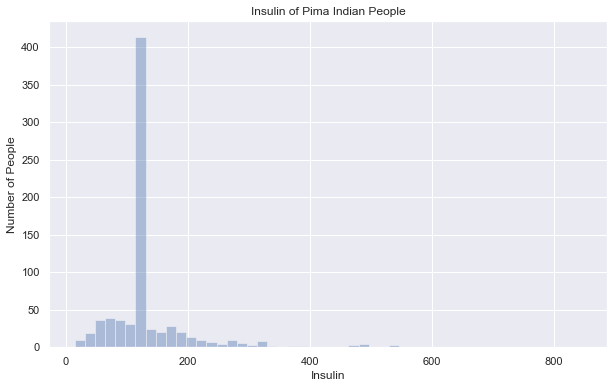

In [18]:
plt.figure(figsize=(10,6))
sns.distplot(diabetes['Insulin'],kde=False,bins=50)
plt.title('Insulin of Pima Indian People')
plt.ylabel('Number of People')
plt.show()

Same case scenario as before. We will see later the correlation between features.

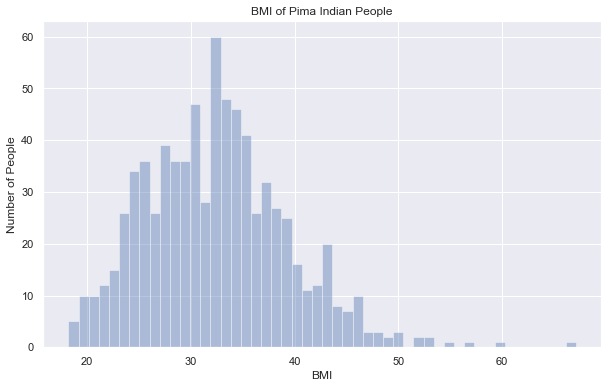

Average BMI of a Pima Person: 32.45520833333333


In [19]:
plt.figure(figsize=(10,6))
sns.distplot(diabetes['BMI'],kde=False,bins=50)
plt.title('BMI of Pima Indian People')
plt.ylabel('Number of People')
plt.show()
print('Average BMI of a Pima Person: ' + str(diabetes['BMI'].mean()))

Well it looks like a normal distribution, which is good. 

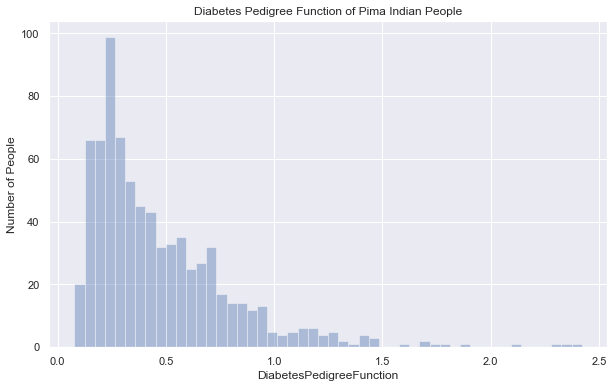

In [20]:
plt.figure(figsize=(10,6))
sns.distplot(diabetes['DiabetesPedigreeFunction'],kde=False,bins=50)
plt.title('Diabetes Pedigree Function of Pima Indian People')
plt.ylabel('Number of People')
plt.show()

Well it looks like a part of a log function or an inversal exp function. I do not like that, and later I will try to modify the data to make a normal gaussian distribution of this data. The reason as I have mentioned before is to make my algorithm work better. [Some of them]

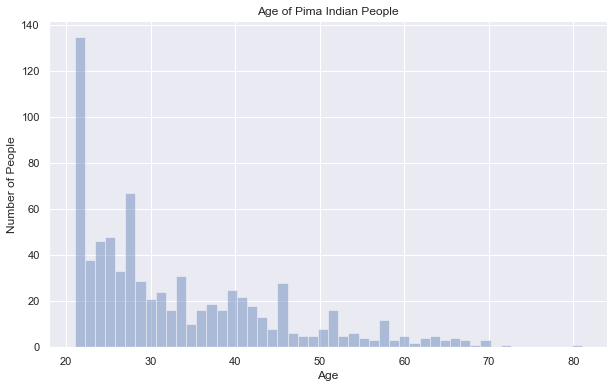

In [21]:
plt.figure(figsize=(10,6))
sns.distplot(diabetes['Age'],kde=False,bins=50)
plt.title('Age of Pima Indian People')
plt.ylabel('Number of People')
plt.show()

Same case as before. It has a lot of young women, and the data is not normalli distributed. Later, I will fix that. It has a lot of young women, so if Age is an important feature, then that majority of young women will make the predictions fall a bit. At the end of the day, they have a lot of weight on this feature.

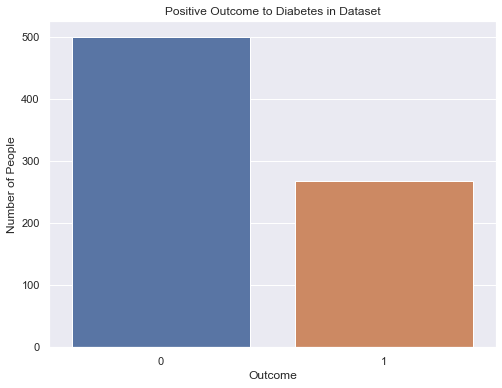

Ratio of Population with Diabetes: 0.3489583333333333


In [22]:
plt.figure(figsize=(8,6))
sns.countplot(x='Outcome',data=diabetes)
plt.title('Positive Outcome to Diabetes in Dataset')
plt.ylabel('Number of People')
plt.show()
print('Ratio of Population with Diabetes: ' + str(len(diabetes[diabetes['Outcome']==1])/len(diabetes)))

So we have an inbalanced dataset. Is not huge, but I cannot allow to exist. I need to mitigate its effect. Because if that, later I will use SMOTE oversampling.


### Bivariate Analysis

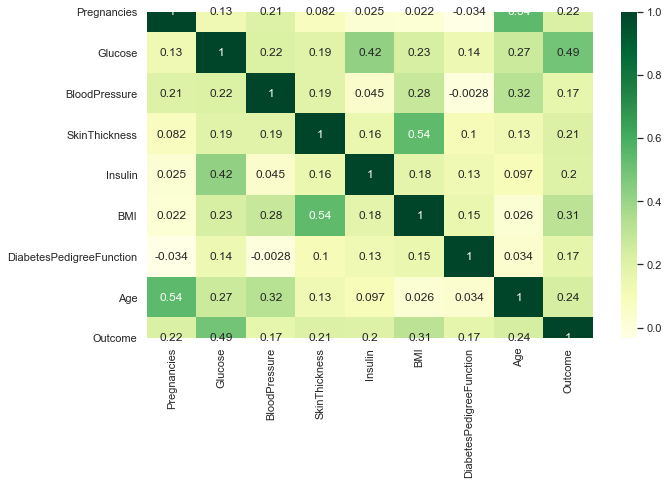

In [23]:
plt.figure(figsize=(10,6))
sns.heatmap(diabetes.corr(),cmap='YlGn',annot=True)
plt.show()

* There are not strong correlation between features which is good. This way, I will not need to drop any feature because of a problem of overfitting.
* There is no feature with a very strong correlation with the label, Outcome. The best is Glucose. I think, that if we had had more Insulin data, it would have a strong correlation. But with what we have, the better predictor is glucose.
* There are some obvious correlations:
    * Skin Thickness with BMI. The fatter you are, the more Skincircunference in your arms.
    * Age with pregnancies. The older you are, it is more possible to have a child.

c:\users\hp\anaconda3\envs\py3mlpr\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


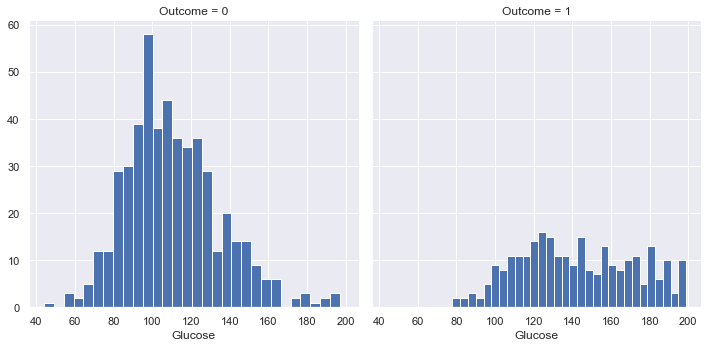

In [24]:
g = sns.FacetGrid(diabetes, col="Outcome",size=5)
g = g.map(plt.hist, "Glucose",bins=30)

In [25]:
print('Average number of glucose for positive outcomes: ' + str(diabetes[diabetes['Outcome']==1]['Glucose'].mean()))
print('Average number of glucose for negative outcomes: ' + str(diabetes[diabetes['Outcome']==0]['Glucose'].mean()))

Average number of glucose for positive outcomes: 142.16557285655603
Average number of glucose for negative outcomes: 110.71012057667103


There is a normal looking population for Pima women without diabetes and their glucose levels. The population with diabetes have a different story to tell. The population with diabetes looks to have higher glucose levels.

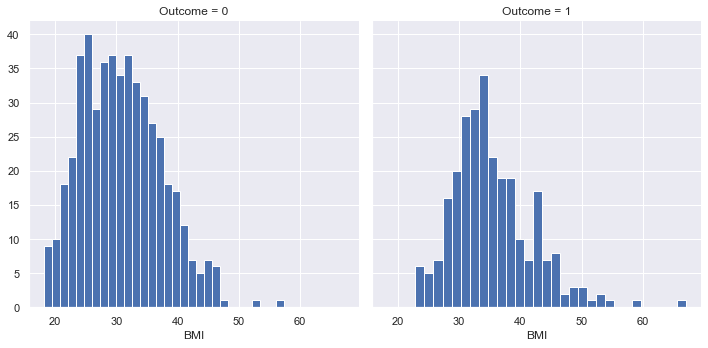

In [26]:
g = sns.FacetGrid(diabetes, col="Outcome",size=5)
g = g.map(plt.hist, "BMI",bins=30)

Both BMI readings for people with and without diabetes seem to have normal distributions. BMI of people with diabetes looks to be with a bit of  higher values, but not something exagerated. But yes, the more BMI the more possible to have diabetes.

In [27]:
print('Average Body Mass Index of a Pima woman without diabetes: ' + str(diabetes[diabetes['Outcome']==0]['BMI'].mean()))
print('Average Body Mass Index of a Pima woman with diabetes: ' + str(diabetes[diabetes['Outcome']==1]['BMI'].mean()))

Average Body Mass Index of a Pima woman without diabetes: 30.885600000000004
Average Body Mass Index of a Pima woman with diabetes: 35.383582089552235


There is no doubt that the population of Pima women are overweight. However, the population with diabetes is even more so.

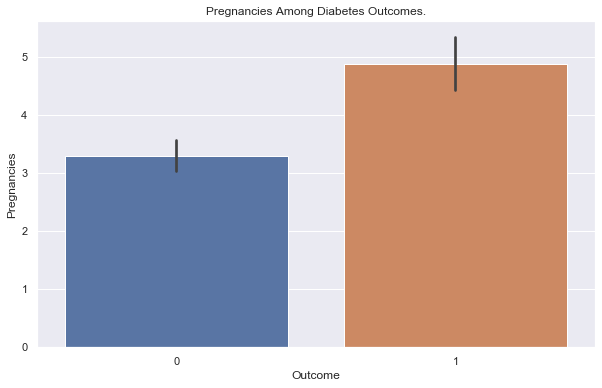

In [28]:
plt.figure(figsize=(10,6))
sns.barplot(data=diabetes,x='Outcome',y='Pregnancies')
plt.title('Pregnancies Among Diabetes Outcomes.')
plt.show()

So the women with fewer childs had less diabetes. I think that there is not much relation between Pregnancies and Outcome, but less think a bit.
* If you have a lot of children, you need to fed them.  And in those cases the less expensive food are carbohhydrates which is the food who moves the Glucose-Insulin cycle. So, perharps is for that. But I dont know.
* Lets see this other graph to grasp a bit of more domain knowledge.

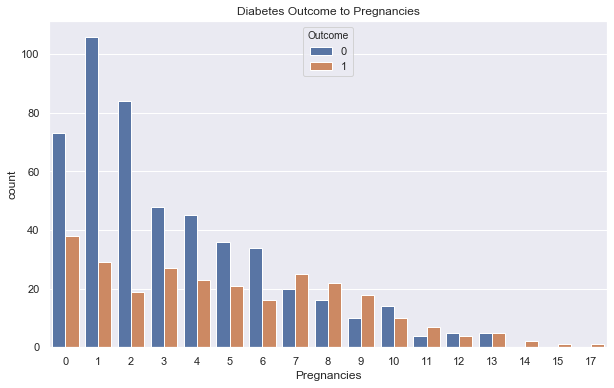

Average number of pregnancies for positive outcomes: 4.865671641791045
Average number of pregnancies for negative outcomes: 3.298


In [29]:
plt.figure(figsize=(10,6))
sns.countplot(x='Pregnancies',data=diabetes,hue='Outcome')
plt.title('Diabetes Outcome to Pregnancies')
plt.show()
print('Average number of pregnancies for positive outcomes: ' + str(diabetes[diabetes['Outcome']==1]['Pregnancies'].mean()))
print('Average number of pregnancies for negative outcomes: ' + str(diabetes[diabetes['Outcome']==0]['Pregnancies'].mean()))

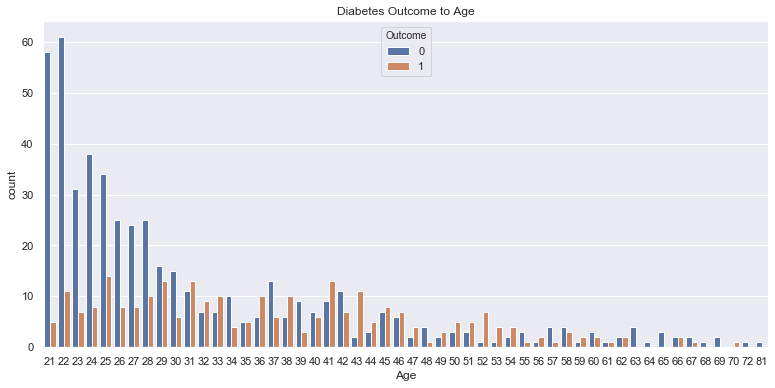

In [30]:
plt.figure(figsize=(13,6))
sns.countplot(x='Age',data=diabetes,hue='Outcome')
plt.title('Diabetes Outcome to Age')
plt.show()

In [31]:
print('Average number of age for positive outcomes: ' + str(diabetes[diabetes['Outcome']==1]['Age'].mean()))
print('Average number of age for negative outcomes: ' + str(diabetes[diabetes['Outcome']==0]['Age'].mean()))

Average number of age for positive outcomes: 37.06716417910448
Average number of age for negative outcomes: 31.19


So, the older you are the most opportunities to have diabetes. And it is normal, at the end of the day, the older you are the more possibilites of having destroy your body with bad habits.

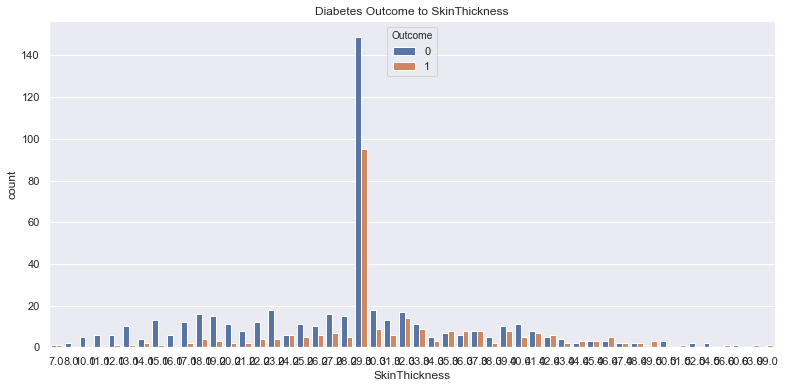

In [32]:
plt.figure(figsize=(13,6))
sns.countplot(x='SkinThickness',data=diabetes,hue='Outcome')
plt.title('Diabetes Outcome to SkinThickness')
plt.show()

In [33]:
print('Average number of skin thickness for positive outcomes: ' + str(diabetes[diabetes['Outcome']==1]['SkinThickness'].mean()))
print('Average number of skin thickness for negative outcomes: ' + str(diabetes[diabetes['Outcome']==0]['SkinThickness'].mean()))

Average number of skin thickness for positive outcomes: 31.686567164179106
Average number of skin thickness for negative outcomes: 27.726


Well this data is no so representative. Remember that we plugged in more than 250 values that did not exist. Anyways, what is clear is that the more fat you have around your arm [that is the measure of skin thickness], the more probabilities of developing diabetes. So, it has a lot of relation with BMI.

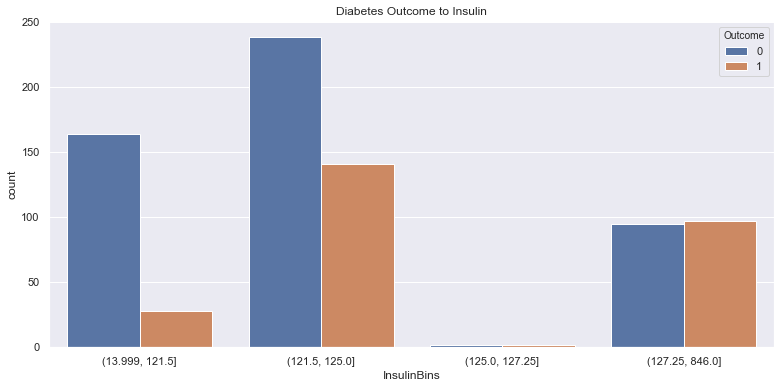

In [34]:
# Diabetes has a lot of values, so to plot it I need to make a few changes. The most important one is to
# divide it in quartiles.
diabetes_copy2= diabetes.copy(deep=True)
diabetes_copy2["InsulinBins"]=pd.qcut(diabetes["Insulin"],4)
#Now we can plot
plt.figure(figsize=(13,6))
sns.countplot(x='InsulinBins',data=diabetes_copy2,hue='Outcome')
plt.title('Diabetes Outcome to Insulin')
plt.show()

In [35]:
print('Average number of Insulin for positive outcomes: ' + str(diabetes[diabetes['Outcome']==1]['Insulin'].mean()))
print('Average number of Insulin for negative outcomes: ' + str(diabetes[diabetes['Outcome']==0]['Insulin'].mean()))

Average number of Insulin for positive outcomes: 164.70149253731344
Average number of Insulin for negative outcomes: 127.792


Well same case as skin thickness. I think that with new data, Insulin will be essential to predict diabetes. Anyways, is clear that the higher blood insulin, the higher possibilites of developing diabetes. It has correlation with Glucose.

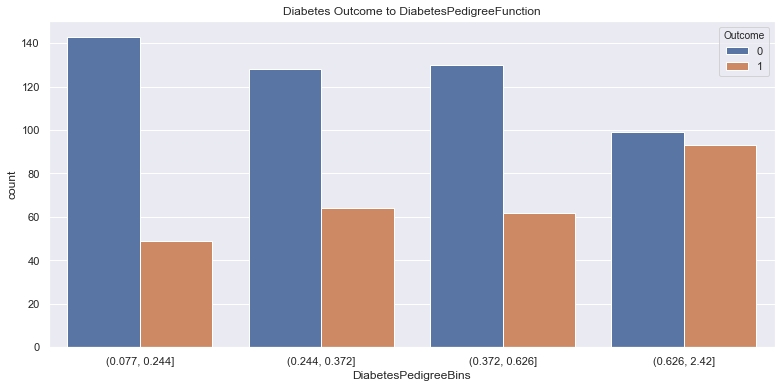

In [36]:
diabetes_copy2["DiabetesPedigreeBins"]=pd.qcut(diabetes["DiabetesPedigreeFunction"],4)
# Same reason as in insulin
plt.figure(figsize=(13,6))
sns.countplot(x='DiabetesPedigreeBins',data=diabetes_copy2,hue='Outcome')
plt.title('Diabetes Outcome to DiabetesPedigreeFunction')
plt.show()

In [37]:
print('Average number of Diabetes Pedigree Function for positive outcomes: ' + str(diabetes[diabetes['Outcome']==1]['DiabetesPedigreeFunction'].mean()))
print('Average number of Diabetes Pedigree Function for negative outcomes: ' + str(diabetes[diabetes['Outcome']==0]['DiabetesPedigreeFunction'].mean()))

Average number of Diabetes Pedigree Function for positive outcomes: 0.5505
Average number of Diabetes Pedigree Function for negative outcomes: 0.42973400000000006


This one is easy and not so easy. The data tell us that if your family has a tendency of having diabetes, you have more possibilites. And I agree with that, but the data does not tell us if this is a genetic question.

* At the end of the day, our nuclear family show us with their actions what is good and bad when we are children. If my parents have developed diabetes because of their bad habits, I will adopt those habits and develope diabetes.
* It also can be a genetic problem. An endocrine problem pass though generations.
* In any case, the data do not specify. So, let us see us.

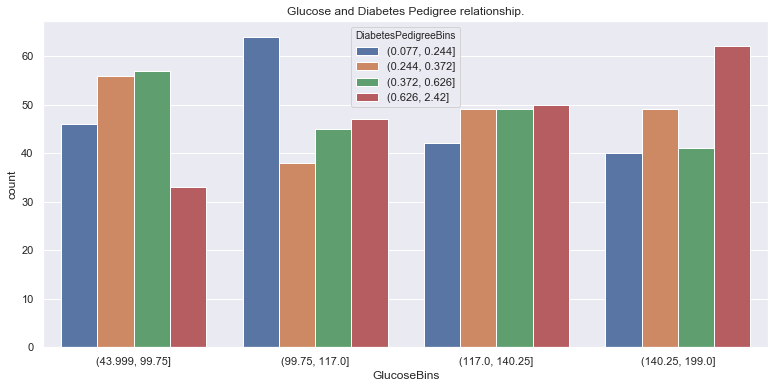

In [38]:
diabetes_copy2["GlucoseBins"]=pd.qcut(diabetes["Glucose"],4)
plt.figure(figsize=(13,6))
sns.countplot(x='GlucoseBins',data=diabetes_copy2,hue='DiabetesPedigreeBins')
plt.title('Glucose and Diabetes Pedigree relationship.')
plt.show()

* The people with less Glucose, tend to be the ones with less family with diabetes. And glucose levels have relation with food, not hormones, so it is not an endocrine problem. With Insulin yes, with glucose no.
* The people with more glucose, tend to have more family with diabetes.
    * So, it seems that it is more a habit problem than a genetic problem.
    * But we are not sure. We need more data, at least insulin data to come to understand well the problem. Is for that reason that i am not going to drop the Pedigree Function. 
    * If the Pedigree function is just for bad habits, then it will not help to predict anything in the real world. Well, it will help to predict how bad habits pass from one generation to the next, but it will not help to say: You are going to have diabetes.

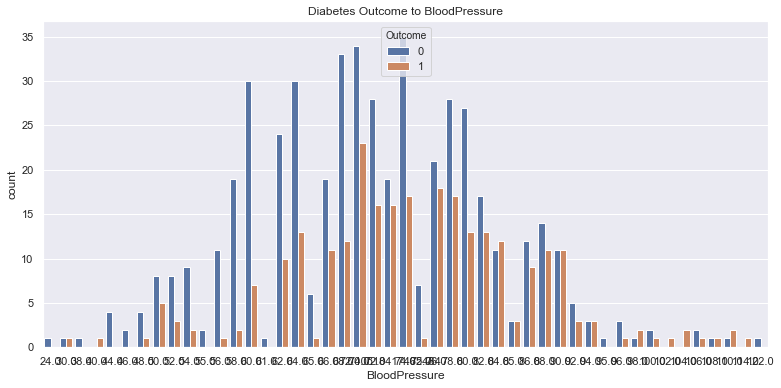

In [39]:
plt.figure(figsize=(13,6))
sns.countplot(x='BloodPressure',data=diabetes,hue='Outcome')
plt.title('Diabetes Outcome to BloodPressure')
plt.show()

In [40]:
print('Average number of Blood Presure for positive outcomes: ' + str(diabetes[diabetes['Outcome']==1]['BloodPressure'].mean()))
print('Average number of Blood Pressure for negative outcomes: ' + str(diabetes[diabetes['Outcome']==0]['BloodPressure'].mean()))

Average number of Blood Presure for positive outcomes: 75.14732442833582
Average number of Blood Pressure for negative outcomes: 70.93539699863575


Well, higher blood pressure, more possibilites of diabetes. But it does not seem to be particularly important. Also, I think that it have relation with BMI. The fatter you are, the more blood pressure in a relaxed state.

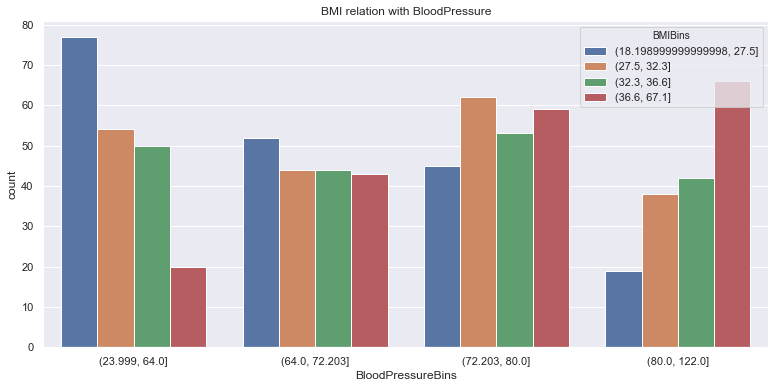

In [41]:
diabetes_copy2["BloodPressureBins"]=pd.qcut(diabetes["BloodPressure"],4)
diabetes_copy2["BMIBins"]=pd.qcut(diabetes["BMI"],4)

plt.figure(figsize=(13,6))
sns.countplot(x='BloodPressureBins',data=diabetes_copy2,hue='BMIBins')
plt.title('BMI relation with BloodPressure')
plt.show()

And the relation is clear as water. When the blood pressure is low, the BMI is low. When the Blood Pressure is high, BMI is high.

### Features and relationships.

* BMI, skin_thickness and blood pressure I think that have a close relation.
* Age and pregnancies.
* Glucose, Insulin and Pedigree.
* Because of all of this, if the dataset was huge, I will drop later pregnancies, blood pressure and other data that is not so important. But this dataset is small, so there is no problem. I will keep all the features.

## Distributed data in a single plot

How is the data distributed among the features? It is useful to know, becauase that way we can do a better feature scaling latter.

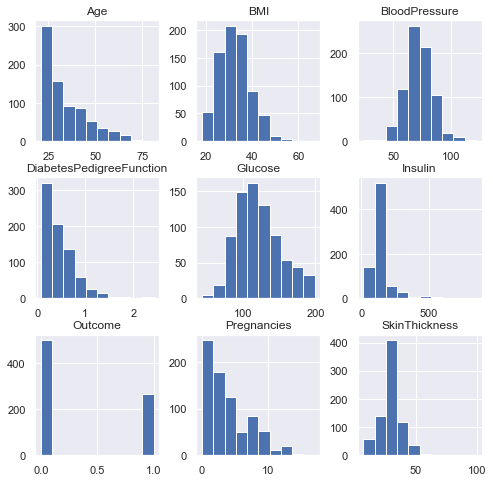

In [42]:
diabetes.hist(figsize=(8,8))
plt.show()

Well, I will do Standar Scaling, to normalize the data. 

# Part 3: Modeling and feature_engineering

Because of that unbalanced dataset I will use roc_auc score as the metric of success. Also I will use the confusion matrix to calculate the sensitivity and specificity. Lasty, I will also use accuracy, but this one does not prove anything in an unbalanced dataset.

I will use a bunch of algorithms. The ones that perform better, will be analyze in more detail [sensitivity, specifity and roc_auc score]

# Baseline model.

I will calculate the roc_auc in each step of cleaning, scaling and oversampling the data, to see how changes the roc_auc, sensitivity, specifity and accuracy through each step.

First thing first. The data with no changes.

### All Algorithms baseline model

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from imblearn.over_sampling import SMOTE  
from imblearn.pipeline import Pipeline as Pipeline
from sklearn.datasets import make_classification
from sklearn.model_selection import (GridSearchCV,StratifiedKFold)

Lets remember that this first modeling is with the data without been clean. The original data.

In [44]:
X=diabetes_copy.drop(["Outcome"], axis=1)
y=diabetes_copy["Outcome"]

In [45]:
scoring = 'roc_auc'
seed=7
models = [] # Here I will append all the algorithms that I will use. Each one will run in all the created datasets.
models.append(('LR', LogisticRegression())) 
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVC()))
models.append(('AdaBoost', AdaBoostClassifier()))

print("evaluation metric: " + scoring)    
results=[]
names=[]
for name, model in models:
        kfold = model_selection.KFold(n_splits=10, random_state=seed)
        cv_results = model_selection.cross_val_score(model,X, y, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        
        
        print ("Algorithm :",name)
        print (" Baseline CV mean: ", cv_results.mean())
        print ("--"*30)


evaluation metric: roc_auc
Algorithm : LR
 Baseline CV mean:  0.8234172339945707
------------------------------------------------------------
Algorithm : LDA
 Baseline CV mean:  0.8286674580537227
------------------------------------------------------------
Algorithm : KNN
 Baseline CV mean:  0.7520031872613351
------------------------------------------------------------


c:\users\hp\anaconda3\envs\py3mlpr\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\hp\anaconda3\envs\py3mlpr\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\hp\anaconda3\envs\py3mlpr\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\hp\anaconda3\envs\py3mlpr\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\hp\anaconda3\envs\py3mlpr\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed

Algorithm : CART
 Baseline CV mean:  0.652288282702496
------------------------------------------------------------
Algorithm : NB
 Baseline CV mean:  0.8183362056817245
------------------------------------------------------------


c:\users\hp\anaconda3\envs\py3mlpr\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\hp\anaconda3\envs\py3mlpr\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\hp\anaconda3\envs\py3mlpr\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\hp\anaconda3\envs\py3mlpr\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\hp\anaconda3\envs\py3mlpr\l

Algorithm : RF
 Baseline CV mean:  0.7867574700372624
------------------------------------------------------------


c:\users\hp\anaconda3\envs\py3mlpr\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\hp\anaconda3\envs\py3mlpr\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\hp\anaconda3\envs\py3mlpr\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\hp\anaconda3\envs\py3mlpr\lib\site-packa

Algorithm : SVM
 Baseline CV mean:  0.6511881577591094
------------------------------------------------------------
Algorithm : AdaBoost
 Baseline CV mean:  0.8175024937690673
------------------------------------------------------------


So, the best algorithms are Logistic Regression and Linear Discriminant.

### Logistic Regression Baseline model

In [46]:
train_X,test_X,train_y,test_y = train_test_split (X,y,test_size=0.2,random_state=3)

model1= LogisticRegression()
fit1 =model1.fit(train_X,train_y)
prediction1= model1.predict(test_X)
confusion= metrics.confusion_matrix(test_y, prediction1)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print ("Baseline model accuracy: ", metrics.accuracy_score(test_y,prediction1))
print ("--"*30)
print ("Baseline matrix confusion: ", "\n",metrics.confusion_matrix(test_y,prediction1))
print ("--"*30)
print ("Baseline sensitivity: ", TP / float(FN + TP))
print ("--"*30)
print ("Baseline model specificity: ", TN / (TN + FP))
print ("--"*30)
print ("Baseline roc auc score: ", "\n", metrics.roc_auc_score(test_y,prediction1))

Baseline model accuracy:  0.7337662337662337
------------------------------------------------------------
Baseline matrix confusion:  
 [[80 12]
 [29 33]]
------------------------------------------------------------
Baseline sensitivity:  0.532258064516129
------------------------------------------------------------
Baseline model specificity:  0.8695652173913043
------------------------------------------------------------
Baseline roc auc score:  
 0.7009116409537166


c:\users\hp\anaconda3\envs\py3mlpr\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


So it has a good ROC AUC score. But, it fails tremendosly in the sensitivity. And the sensitivity, the recall is the thing that we want to improve. 
*Sensitivity: When the actual value is positive, how often is the prediction correct?

How "sensitive" is the classifier to detecting positive instances? Or in other words. If you have diabetes, will it detect it? The sensitivity is going to measure that. So, it needs to increase... A lot.

The problem with sensitivity is that it will detect diabetes to people who dont have diabetes. But it is better that, than sending someone home telling them that they do not have diabetes.

* For example, Imagine if you have cancer. The sensitivity is never going to fail if someone has cancer. But it can tell that someone has cancer withour having it.
* The specificity is going to tell us that the person who have a positive test is going to have cancer for sure. BUT, and it is a big but, if someone who have cancer, have a negative test is going to pass undetected.
* So, for differente imbalanced datasets, you are going to choose between sensitivity and specificity. In all the medical datasets, choose sensitivity.

 ### Linear discriminant analysis Classifier Baseline Model

In [47]:
X=diabetes_copy.drop(["Outcome"], axis=1)
y=diabetes_copy["Outcome"]

train_X,test_X,train_y,test_y = train_test_split (X,y,test_size=0.2,random_state=3)

model2= LinearDiscriminantAnalysis()
fit2 =model2.fit(train_X,train_y)
prediction2= model2.predict(test_X)
confusion= metrics.confusion_matrix(test_y, prediction2)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print ("Baseline model accuracy: ", metrics.accuracy_score(test_y,prediction2))
print ("--"*30)
print ("Baseline matrix confusion: ", "\n",metrics.confusion_matrix(test_y,prediction2))
print ("--"*30)
print ("Baseline sensitivity: ", TP / float(FN + TP))
print ("--"*30)
print ("Baseline model specificity: ", TN / (TN + FP))
print ("--"*30)
print ("Baseline roc auc score: ", "\n", metrics.roc_auc_score(test_y,prediction2))

Baseline model accuracy:  0.7337662337662337
------------------------------------------------------------
Baseline matrix confusion:  
 [[78 14]
 [27 35]]
------------------------------------------------------------
Baseline sensitivity:  0.5645161290322581
------------------------------------------------------------
Baseline model specificity:  0.8478260869565217
------------------------------------------------------------
Baseline roc auc score:  
 0.7061711079943899


So in the baseline model, LDA is the best. It performs poorly, but has better sensitivity than Logistic Regression.

#  Model with the data clean.

The step that  I have perfomed at the beginning

### All algorithms model with the data clean

In [48]:
X=diabetes.drop(["Outcome"], axis=1)
y=diabetes["Outcome"]

In [49]:
scoring = 'roc_auc'
seed=7
models = [] # Here I will append all the algorithms that I will use. Each one will run in all the created datasets.
models.append(('LR', LogisticRegression())) 
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVC()))
models.append(('AdaBoost', AdaBoostClassifier()))

print("evaluation metric: " + scoring)    
results=[]
names=[]
for name, model in models:
        kfold = model_selection.KFold(n_splits=10, random_state=seed)
        cv_results = model_selection.cross_val_score(model,X, y, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        
        
        print ("Algorithm :",name)
        print (" Data clean CV mean: ", cv_results.mean())
        print ("--"*30)


evaluation metric: roc_auc
Algorithm : LR
 Data clean CV mean:  0.8273718438027761
------------------------------------------------------------
Algorithm : LDA
 Data clean CV mean:  0.8367641220233007
------------------------------------------------------------
Algorithm : KNN
 Data clean CV mean:  0.7683671235623712
------------------------------------------------------------


c:\users\hp\anaconda3\envs\py3mlpr\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\hp\anaconda3\envs\py3mlpr\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\hp\anaconda3\envs\py3mlpr\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\hp\anaconda3\envs\py3mlpr\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\hp\anaconda3\envs\py3mlpr\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed

Algorithm : CART
 Data clean CV mean:  0.6717464043583106
------------------------------------------------------------
Algorithm : NB
 Data clean CV mean:  0.8169220878799963
------------------------------------------------------------
Algorithm : RF
 Data clean CV mean:  0.8081347793996315
------------------------------------------------------------


c:\users\hp\anaconda3\envs\py3mlpr\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\hp\anaconda3\envs\py3mlpr\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\hp\anaconda3\envs\py3mlpr\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\hp\anaconda3\envs\py3mlpr\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\hp\anaconda3\envs\py3mlpr\l

Algorithm : SVM
 Data clean CV mean:  0.6819594062222089
------------------------------------------------------------
Algorithm : AdaBoost
 Data clean CV mean:  0.8141773547987489
------------------------------------------------------------


Again, the best algorithms are LDA and Logistic Regression

## Logistic Regression data clean

In [50]:
train_X,test_X,train_y,test_y = train_test_split (X,y,test_size=0.2,random_state=3)

model3=LogisticRegression()
fit3 =model3.fit(train_X,train_y)
prediction3= model3.predict(test_X)
confusion= metrics.confusion_matrix(test_y, prediction3)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

print ("Data clean model roc auc score: ",metrics.roc_auc_score(test_y,prediction3))
print ("__"*30)
print ("Data clean model matrix confusion: ", "\n",metrics.confusion_matrix(test_y,prediction3))
print ("--"*30)
print ("Data clean model sensitivity: ", TP / float(FN + TP))
print ("--"*30)
print ("Data clean model specificity: ", TN / (TN + FP))
print ("__"*30)
print ("Data clean model accuracy: ", metrics.accuracy_score(test_y,prediction3))


Data clean model roc auc score:  0.6577840112201964
____________________________________________________________
Data clean model matrix confusion:  
 [[78 14]
 [33 29]]
------------------------------------------------------------
Data clean model sensitivity:  0.46774193548387094
------------------------------------------------------------
Data clean model specificity:  0.8478260869565217
____________________________________________________________
Data clean model accuracy:  0.6948051948051948


c:\users\hp\anaconda3\envs\py3mlpr\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Well, a disaster. The sensitivity has plummed. It could be because of the fill in the NaN values with the median. Lets see how performs LDA.

### Linear discriminant analysis with the data clean

In [51]:
train_X,test_X,train_y,test_y = train_test_split (X,y,test_size=0.2,random_state=3)

model4=LinearDiscriminantAnalysis()
fit4 =model4.fit(train_X,train_y)
prediction4= model4.predict(test_X)
confusion= metrics.confusion_matrix(test_y, prediction4)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

print ("Data clean model roc auc score: ",metrics.roc_auc_score(test_y,prediction4))
print ("__"*30)
print ("Data clean model matrix confusion: ", "\n",metrics.confusion_matrix(test_y,prediction4))
print ("--"*30)
print ("Data clean model sensitivity: ", TP / float(FN + TP))
print ("--"*30)
print ("Data clean model specificity: ", TN / (TN + FP))
print ("__"*30)
print ("Data clean model accuracy: ", metrics.accuracy_score(test_y,prediction4))

Data clean model roc auc score:  0.6819775596072931
____________________________________________________________
Data clean model matrix confusion:  
 [[78 14]
 [30 32]]
------------------------------------------------------------
Data clean model sensitivity:  0.5161290322580645
------------------------------------------------------------
Data clean model specificity:  0.8478260869565217
____________________________________________________________
Data clean model accuracy:  0.7142857142857143


Also, the results looks very very bad. Lets scale and normalize the datasets to make everything work better. The reason is for the filling with the median. It has change the distribution, so it is time to normalize it, and with that lets expect an increment in sensitivity

 # Modeling with the data clean and scaled

In [52]:
from sklearn.preprocessing import StandardScaler
X=diabetes.drop(["Outcome"],axis=1)
print (X.info())
columnas=["Pregnancies","Glucose","BloodPressure","SkinThickness","Insulin","BMI","DiabetesPedigreeFunction","Age"]
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X=pd.DataFrame(X_scaled, columns=[columnas])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 8 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null float64
BloodPressure               768 non-null float64
SkinThickness               768 non-null float64
Insulin                     768 non-null float64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
dtypes: float64(6), int64(2)
memory usage: 48.1 KB
None


In [53]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.639947,0.865108,-0.033518,0.670643,-0.181541,0.166619,0.468492,1.425995
1,-0.844885,-1.206162,-0.529859,-0.012301,-0.181541,-0.852200,-0.365061,-0.190672
2,1.233880,2.015813,-0.695306,-0.012301,-0.181541,-1.332500,0.604397,-0.105584
3,-0.844885,-1.074652,-0.529859,-0.695245,-0.540642,-0.633881,-0.920763,-1.041549
4,-1.141852,0.503458,-2.680669,0.670643,0.316566,1.549303,5.484909,-0.020496


### All algorithms modeling with the data clean and scaled.

In [54]:
scoring = 'roc_auc'
seed=7
models = [] # Here I will append all the algorithms that I will use. Each one will run in all the created datasets.
models.append(('LR', LogisticRegression())) 
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVC()))
models.append(('AdaBoost', AdaBoostClassifier()))

print("evaluation metric: " + scoring)    
results=[]
names=[]
for name, model in models:
        kfold = model_selection.KFold(n_splits=10, random_state=seed)
        cv_results = model_selection.cross_val_score(model,X, y, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        
        
        print ("Algorithm :",name)
        print (" Data clean & scaled CV mean: ", cv_results.mean())
        print ("--"*30)

evaluation metric: roc_auc
Algorithm : LR
 Data clean & scaled CV mean:  0.8362339876308221
------------------------------------------------------------
Algorithm : LDA
 Data clean & scaled CV mean:  0.8367641220233007
------------------------------------------------------------
Algorithm : KNN
 Data clean & scaled CV mean:  0.7940334459228421
------------------------------------------------------------


c:\users\hp\anaconda3\envs\py3mlpr\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\hp\anaconda3\envs\py3mlpr\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\hp\anaconda3\envs\py3mlpr\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\hp\anaconda3\envs\py3mlpr\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\hp\anaconda3\envs\py3mlpr\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed

Algorithm : CART
 Data clean & scaled CV mean:  0.6756453241375293
------------------------------------------------------------
Algorithm : NB
 Data clean & scaled CV mean:  0.8169220878799963
------------------------------------------------------------


c:\users\hp\anaconda3\envs\py3mlpr\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\hp\anaconda3\envs\py3mlpr\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\hp\anaconda3\envs\py3mlpr\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\hp\anaconda3\envs\py3mlpr\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\hp\anaconda3\envs\py3mlpr\l

Algorithm : RF
 Data clean & scaled CV mean:  0.7838725250093546
------------------------------------------------------------
Algorithm : SVM
 Data clean & scaled CV mean:  0.8303461062152421
------------------------------------------------------------


c:\users\hp\anaconda3\envs\py3mlpr\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\hp\anaconda3\envs\py3mlpr\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\hp\anaconda3\envs\py3mlpr\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\hp\anaconda3\envs\py3mlpr\lib\site-packa

Algorithm : AdaBoost
 Data clean & scaled CV mean:  0.8141773547987489
------------------------------------------------------------


### Logistic Regression data clean and scaled

In [55]:
train_X,test_X,train_y,test_y = train_test_split (X,y,test_size=0.2,random_state=3)

model5= LogisticRegression()
fit5 =model5.fit(train_X,train_y)
prediction5= model5.predict(test_X)
confusion= metrics.confusion_matrix(test_y, prediction5)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

print ("Data clean & scaled roc auc score: ", "\n", metrics.roc_auc_score(test_y,prediction5))
print ("--"*30)
print ("Data clean & scaled matrix confusion: ", "\n",metrics.confusion_matrix(test_y,prediction5))
print ("--"*30)
print ("Data clean & scaled model sensitivity: ", TP / float(FN + TP))
print ("--"*30)
print ("Data clean & scaled model specificity: ", TN / (TN + FP))
print ("__"*30)
print ("Data clean & scaled model accuracy: ", metrics.accuracy_score(test_y,prediction5))


Data clean & scaled roc auc score:  
 0.708976157082749
------------------------------------------------------------
Data clean & scaled matrix confusion:  
 [[80 12]
 [28 34]]
------------------------------------------------------------
Data clean & scaled model sensitivity:  0.5483870967741935
------------------------------------------------------------
Data clean & scaled model specificity:  0.8695652173913043
____________________________________________________________
Data clean & scaled model accuracy:  0.7402597402597403


c:\users\hp\anaconda3\envs\py3mlpr\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


And now we can see an improve.

### Linear discriminant Analysis Data clean and scaled

In [56]:
train_X,test_X,train_y,test_y = train_test_split (X,y,test_size=0.2,random_state=3)

model= LinearDiscriminantAnalysis()
fit6 =model.fit(train_X,train_y)
prediction6= model.predict(test_X)
confusion= metrics.confusion_matrix(test_y, prediction6)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

print ("Data clean & scaled roc auc score: ", "\n", metrics.roc_auc_score(test_y,prediction6))
print ("--"*30)
print ("Data clean & scaled matrix confusion: ", "\n",metrics.confusion_matrix(test_y,prediction6))
print ("--"*30)
print ("Data clean & scaled model sensitivity: ", TP / float(FN + TP))
print ("--"*30)
print ("Data clean & scaled model specificity: ", TN / (TN + FP))
print ("__"*30)
print ("Data clean & scaled model accuracy: ", metrics.accuracy_score(test_y,prediction6))


Data clean & scaled roc auc score:  
 0.6819775596072931
------------------------------------------------------------
Data clean & scaled matrix confusion:  
 [[78 14]
 [30 32]]
------------------------------------------------------------
Data clean & scaled model sensitivity:  0.5161290322580645
------------------------------------------------------------
Data clean & scaled model specificity:  0.8478260869565217
____________________________________________________________
Data clean & scaled model accuracy:  0.7142857142857143


# Smoke, GridSearch, CV.

Because Logistic Regression and LDA have been the best algorithms, I will keep working with them. 
* At the beginning I analized the distribution of the outcome. It showed and inbalanced dataset. And the problem with that is that some algorithms, like Logistic Regression, place more weight in the majority class. In this case, not having diabetes--> Low sensitivity---> Something awful.
* To avoid that, we can oversample or undersample.
    * Because we have few samples i Will oversample. And I will do it with the SMOTE technique.

### Logistic Regression Oversampling with Smote

In [57]:
from imblearn.over_sampling import SMOTE  
from imblearn.pipeline import Pipeline as Pipeline

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (GridSearchCV,StratifiedKFold)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=444, stratify=y)

pipe = Pipeline([
    ('oversample', SMOTE(random_state=444)),
    ('clf', LogisticRegression(random_state=444, n_jobs=-1))
    ])

skf = StratifiedKFold(n_splits=10)
param_grid = {'clf__C': [0.001,0.01,0.1,1,10,100],
              'clf__penalty': ['l1', 'l2']}
grid = GridSearchCV(pipe, param_grid, return_train_score=False,
                    n_jobs=-1, scoring="roc_auc", cv=skf)
logreg=grid.fit(X_train, y_train)
grid.score(X_test, y_test)
# View best hyperparameters
prediction7= grid.predict(X_test)
confusion= metrics.confusion_matrix(y_test, prediction7)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

print ("SMOTE roc auc score: ", "\n", metrics.roc_auc_score(y_test,prediction7))
print ("--"*30)
print ("SMOTE matrix confusion: ", "\n",metrics.confusion_matrix(y_test,prediction7))
print ("--"*30)
print ("SMOTE sensitivity: ", TP / float(FN + TP))
print ("--"*30)
print ("SMOTE model specificity: ", TN / (TN + FP))
print ("__"*30)
print ("SMOTE model accuracy: ", metrics.accuracy_score(y_test,prediction7))
print ("--"*30)

print('Best Penalty:', grid.best_estimator_.get_params()['clf__penalty'])
print('Best C:', grid.best_estimator_.get_params()['clf__C'])




SMOTE roc auc score:  
 0.7703438883214163
------------------------------------------------------------
SMOTE matrix confusion:  
 [[130  35]
 [ 22  67]]
------------------------------------------------------------
SMOTE sensitivity:  0.7528089887640449
------------------------------------------------------------
SMOTE model specificity:  0.7878787878787878
____________________________________________________________
SMOTE model accuracy:  0.7755905511811023
------------------------------------------------------------
Best Penalty: l1
Best C: 0.1


c:\users\hp\anaconda3\envs\py3mlpr\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\hp\anaconda3\envs\py3mlpr\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


And a huge incremente in sensitivity and Roc.

### Linear Discriminant analysis Classifier oversampling with SMOTE

In [58]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=444, stratify=y)

pipe2 = Pipeline([
    ('oversample', SMOTE(random_state=444)),
    ('clf', LinearDiscriminantAnalysis())])

skf2 = StratifiedKFold(n_splits=10)
param_grid = {'clf__n_components': [1]}
grid = GridSearchCV(pipe2, param_grid, return_train_score=False,
                    n_jobs=-1, scoring="roc_auc", cv=skf2)
LDA=grid.fit(X_train, y_train)
grid.score(X_test, y_test)
# View best hyperparameters
prediction8= LDA.predict(X_test)
confusion2= metrics.confusion_matrix(y_test, prediction8)
TP = confusion2[1, 1]
TN = confusion2[0, 0]
FP = confusion2[0, 1]
FN = confusion2[1, 0]

print ("SMOTE roc auc score: ", "\n", metrics.roc_auc_score(y_test,prediction8))
print ("--"*30)
print ("SMOTE matrix confusion: ", "\n",metrics.confusion_matrix(y_test,prediction8))
print ("--"*30)
print ("SMOTE sensitivity: ", TP / float(FN + TP))
print ("--"*30)
print ("SMOTE model specificity: ", TN / (TN + FP))
print ("__"*30)
print ("SMOTE model accuracy: ", metrics.accuracy_score(y_test,prediction8))
print ("--"*30)

print('Best Number of components:', grid.best_estimator_.get_params()['clf__n_components'])


SMOTE roc auc score:  
 0.7656111678583589
------------------------------------------------------------
SMOTE matrix confusion:  
 [[134  31]
 [ 25  64]]
------------------------------------------------------------
SMOTE sensitivity:  0.7191011235955056
------------------------------------------------------------
SMOTE model specificity:  0.8121212121212121
____________________________________________________________
SMOTE model accuracy:  0.7795275590551181
------------------------------------------------------------
Best Number of components: 1


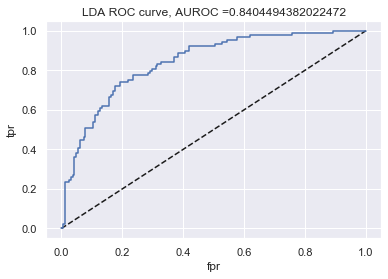

AUROC =  0.8404494382022472


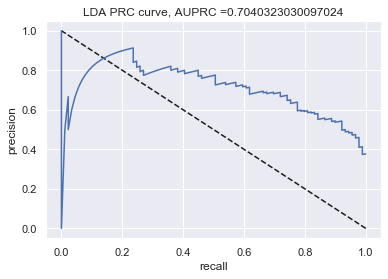

AUPRC =  0.7040323030097024
AUROC =  0.8404494382022472 , AUPRC =  0.7040323030097024 . Best threshold for ROC =  0.46555766171966545 , accuracy is then  0.7637795275590551 .
SMOTE roc auc score:  
 0.7656111678583589
------------------------------------------------------------
SMOTE matrix confusion:  
 [[134  31]
 [ 25  64]]
------------------------------------------------------------
SMOTE sensitivity:  0.7191011235955056
------------------------------------------------------------
SMOTE model specificity:  0.8121212121212121
____________________________________________________________
SMOTE model accuracy:  0.7795275590551181
------------------------------------------------------------
Best Number of components: 1


c:\users\hp\anaconda3\envs\py3mlpr\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


In [73]:
# added by Sheryl
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=444, stratify=y)

pipe2 = Pipeline([
    ('oversample', SMOTE(random_state=444)),
    ('clf', LinearDiscriminantAnalysis())])

skf2 = StratifiedKFold(n_splits=10)
param_grid = {'clf__n_components': [1]}
grid = GridSearchCV(pipe2, param_grid, return_train_score=False,
                    n_jobs=-1, scoring="roc_auc", cv=skf2)
LDA=grid.fit(X_train, y_train)
grid.score(X_test, y_test)
# View best hyperparameters
prediction8= LDA.predict(X_test)
confusion2= metrics.confusion_matrix(y_test, prediction8)
TP = confusion2[1, 1]
TN = confusion2[0, 0]
FP = confusion2[0, 1]
FN = confusion2[1, 0]
from sklearn.metrics import roc_curve
y_pred_proba =LDA.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
#Area under ROC curve
from sklearn.metrics import roc_auc_score
auroc = roc_auc_score(y_test,y_pred_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='LDA')
plt.xlabel('fpr')
plt.ylabel('tpr')
title_name = 'LDA ROC curve, AUROC ='+str(auroc)
plt.title(title_name)
plt.savefig('LDA ROC curve.png')
plt.show()
print('AUROC = ',auroc)
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test,y_pred_proba)
from sklearn.metrics import auc
auprc = auc(recall, precision)
plt.plot([1,0],[0,1],'k--')
plt.plot(recall,precision, label='LDA')
plt.xlabel('recall')
plt.ylabel('precision')
title_name = 'LDA PRC curve, AUPRC ='+str(auprc)
plt.title(title_name)
plt.savefig('LDA PRC curve.png')
plt.show()
print('AUPRC = ',auprc)
threshold = Find_Optimal_Cutoff(y_test,y_pred_proba)
from sklearn.metrics import accuracy_score
y_pred = y_pred_proba>threshold
accuracy = accuracy_score(y_test, y_pred)

# report of scores
print('AUROC = ',auroc,', AUPRC = ',auprc,'. Best threshold for ROC = ',threshold[0], ', accuracy is then ',accuracy,'.')
# end of sections added by Sheryl
print ("SMOTE roc auc score: ", "\n", metrics.roc_auc_score(y_test,prediction8))
print ("--"*30)
print ("SMOTE matrix confusion: ", "\n",metrics.confusion_matrix(y_test,prediction8))
print ("--"*30)
print ("SMOTE sensitivity: ", TP / float(FN + TP))
print ("--"*30)
print ("SMOTE model specificity: ", TN / (TN + FP))
print ("__"*30)
print ("SMOTE model accuracy: ", metrics.accuracy_score(y_test,prediction8))
print ("--"*30)

print('Best Number of components:', grid.best_estimator_.get_params()['clf__n_components'])


Also, a huge increment. But in hear the sensitivity is not as good as in the Logistic Regression, so I will keep working with that algorithm.

# Sensitivity Threshold and ROC curve

We have seen now, how the roc auc is growing. But we have a little problem. 
The specificity is going down. Is this a bad thing?
Well no. In this case is not, because here we are interested in the sensitivity.

* A high specificity tell us that the correct things are going to be well classified. This is good.
* A high sensitivity tell us that we are not going to allow any person with diabetes to be classified as a healthy person.
* In a medical work, is more important to not allow mistakes, rather than making good predictions. So, the good thing now is to improve the sensitivity.
* Now, I will analyze the sensitivity threshold and see how everything changes. I will be working with the LogisticRegression of the SMOTE technique.

Lets start seeing the first 10 predicted responses.

In [59]:
logreg.predict(X_test)[0:10]

array([0, 1, 0, 0, 0, 0, 1, 0, 0, 1], dtype=int64)

Now, lets see the 10 predicted probabilites for each label. Outcome diabetes and Outcome not diabetes.

In [60]:
logreg.predict_proba(X_test)[0:10]

array([[0.66254743, 0.33745257],
       [0.18424673, 0.81575327],
       [0.64649514, 0.35350486],
       [0.85640608, 0.14359392],
       [0.82714927, 0.17285073],
       [0.79078571, 0.20921429],
       [0.26090955, 0.73909045],
       [0.6653793 , 0.3346207 ],
       [0.61249907, 0.38750093],
       [0.19625758, 0.80374242]])

Each row, numbers sum to 1 (total probability), and we have two columns:

* column 0: predicted probability that each observation is a member of the non diabetic group
* column 1: predicted probability that each observation is a member of the diabetic group.
    * Now with that information we can now work with another probability. We can choose the class with the highest probability with the predict proba process. And with that, we can see the classification threshold. Lets continue with the code to understand it better.


Lets see the first 10 predicted probabilities for the diabetic group.

In [61]:
logreg.predict_proba(X_test)[0:10, 1]

array([0.33745257, 0.81575327, 0.35350486, 0.14359392, 0.17285073,
       0.20921429, 0.73909045, 0.3346207 , 0.38750093, 0.80374242])

So, the first one has 33% posibilities to be a diabetic person. The same with the others.
Now, lets save that data to plot it.

In [62]:
y_pred_prob = logreg.predict_proba(X_test)[:, 1] # Here I saved all the samples, not just 10.

Text(0, 0.5, 'Frequency')

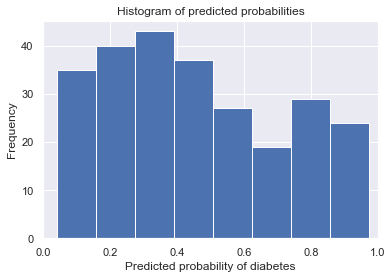

In [63]:
plt.hist(y_pred_prob, bins=8)

# x-axis limit from 0 to 1
plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of diabetes')
plt.ylabel('Frequency')

We see that around the 3-4 bar we have almost all the predictions. This is because the threshold is by default around 0.5. If we change it, we can change also the specificity and sensitivity of our model. And in this case we want to do it to increase the sensitivity.

Lets see how to change it.

In [64]:
from sklearn.preprocessing import binarize
y_pred_prob=y_pred_prob.reshape(1,-1)
# it will return 1 for all values above 0.3 and 0 otherwise
# results are 2D so we slice out the first column
y_pred_class = binarize(y_pred_prob, 0.3)[0]

In [65]:
y_pred_prob[0:10]

array([[0.33745257, 0.81575327, 0.35350486, 0.14359392, 0.17285073,
        0.20921429, 0.73909045, 0.3346207 , 0.38750093, 0.80374242,
        0.19814671, 0.87565964, 0.26169891, 0.59158945, 0.79346015,
        0.08437106, 0.26906019, 0.29366593, 0.95544501, 0.48170307,
        0.95640196, 0.22213242, 0.45352973, 0.45275279, 0.58476668,
        0.33955563, 0.70245922, 0.40834855, 0.11555938, 0.62199271,
        0.43870053, 0.16526976, 0.15077485, 0.13246018, 0.79249231,
        0.77367876, 0.12182647, 0.18310725, 0.04688871, 0.1666174 ,
        0.65664488, 0.30868166, 0.65404612, 0.25966572, 0.40502523,
        0.74966143, 0.85023036, 0.20288758, 0.22782821, 0.6715081 ,
        0.73067752, 0.04238047, 0.57096924, 0.36580841, 0.8356348 ,
        0.09652641, 0.8836943 , 0.84732997, 0.51720623, 0.38732931,
        0.44921225, 0.18257703, 0.42151603, 0.61364487, 0.32024821,
        0.74812858, 0.15267069, 0.44969665, 0.8653521 , 0.2941151 ,
        0.39414726, 0.11990434, 0.70241121, 0.93

In [66]:
y_pred_class[0:10]

array([1., 1., 1., 0., 0., 0., 1., 1., 1., 1.])

And this way you can change the sensitivity threshold. Anyways, continue with the code to see how to do it. But in essence, I just need to change the value of binarize to other threshold, and the sensitivity and specificity will change.

# ROC curve

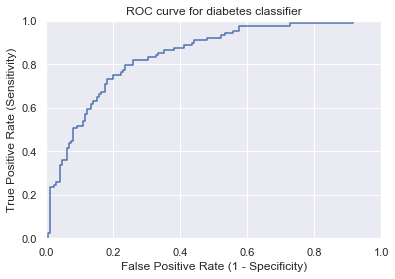

In [67]:
y_pred_prob = logreg.predict_proba(X_test)[:, 1] # remember that equation
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

ROC curve can help you  choose a threshold that balances sensitivity and specificity in a way that makes sense for the  context. We cannot see the threshold but we can compute them. 
* Anyway, we need to find a balance between sensitivity and specifity now.


In [68]:
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

Now we can see how the values of sensitivity and specifity choosing the threshold. When we find one that we like, we can change the value of the binarize and get an extremely optimized model.

In [69]:
evaluate_threshold(0.5) # For example.

Sensitivity: 0.7528089887640449
Specificity: 0.8


Now, lets compute the AUC and finish the work of our model.
*AUC is the percentage of the ROC plot that is underneath the curve:

In [70]:
print(metrics.roc_auc_score(y_test, y_pred_prob))

0.8411985018726592


In [71]:
from sklearn.cross_validation import cross_val_score
cross_val_score(logreg, X, y, cv=10, scoring='roc_auc').mean()

ModuleNotFoundError: No module named 'sklearn.cross_validation'

And we have finish. We have a model with a 0.836 % in roc_auc metric, so it is extremely well balanced for this dataset. Also, we can change our threshold and get more specificity or sensitivity whenever we want.

And that is all.